## Collect pretrained transformers from different models

**Steps**:

1. Collect features.
2. Do analysis with ANOVA https://www.reneshbedre.com/blog/anova.html
3. Select the best model | Do feature significance : https://pages.pomona.edu/~jsh04747/courses/math158/multlin4.pdf 

In [2]:
import os
import string
import pickle
import pandas as pd
import numpy as np
import torch
from collections import defaultdict

### Load datasets

In [3]:
import os
import string

data_folder = 'wmt2016-seg-metric-dev-5lps/de-en'

mt_txt_path = os.path.join(data_folder, 'newstest2015.mt-system.de-en')
human_score_path = os.path.join(data_folder, 'newstest2015.human.de-en')
ref_txt_path = os.path.join(data_folder, 'newstest2015.reference.de-en')
bleu_score_path = os.path.join(data_folder, 'newstest2015.sbleumoses.de-en')
srs_path = os.path.join(data_folder, 'newstest2015.source.de-en')

In [4]:
# WMT 15

data_folder = os.path.join(os.pardir, 'data', 'wmt15', 'de-en')

mt_txt_path = os.path.join(data_folder, 'newstest2015.mt-system.de-en')
human_score_path = os.path.join(data_folder, 'newstest2015.human.de-en')
ref_txt_path = os.path.join(data_folder, 'newstest2015.reference.de-en')
bleu_score_path = os.path.join(data_folder, 'newstest2015.sbleumoses.de-en')
srs_path = os.path.join(data_folder, 'newstest2015.source.de-en')

with open(ref_txt_path) as f:
    ref_snts_15 = f.read().splitlines()

with open(srs_path) as f:
    src_snts_15 = f.read().splitlines()

with open(mt_txt_path) as f:
    mt_snts_15 = f.read().splitlines()

with open(human_score_path) as f:
    da_scores_15 = f.read().splitlines()
    da_scores_15 = [float(s) for s in da_scores_15]

with open(bleu_score_path) as f:
    sbleu_scores_15 = f.read().splitlines()
    sbleu_scores_15 = [float(s) for s in sbleu_scores_15]

In [397]:
# WMT 16

data_folder = os.path.join(os.pardir, 'data', 'wmt16')

mt_txt_path_16 = os.path.join(data_folder, 'DAseg.newstest2016.mt-system.de-en')
human_score_path_16 = os.path.join(data_folder, 'DAseg.newstest2016.human.de-en')
ref_txt_path_16 = os.path.join(data_folder, 'DAseg.newstest2016.reference.de-en')
srs_path_16 = os.path.join(data_folder, 'DAseg.newstest2016.source.de-en')

with open(ref_txt_path_16) as f:
    ref_snts_16 = f.read().splitlines()

with open(srs_path_16) as f:
    src_snts_16 = f.read().splitlines()

with open(mt_txt_path_16) as f:
    mt_snts_16 = f.read().splitlines()

with open(human_score_path_16) as f:
    da_scores_16 = f.read().splitlines()
    da_scores_16 = [float(s) for s in da_scores_16]

In [5]:
# WMT 21

wmt_data_folder = '../data/wmt21/preprocessed_data'

ref_path = os.path.join(wmt_data_folder, 'all_ref_snts_21.pickle')
mt_path = os.path.join(wmt_data_folder, 'all_mt_snts_21.pickle')
srs_path = os.path.join(wmt_data_folder, 'all_src_snts_21.pickle')
mqm_scores_path = os.path.join(wmt_data_folder, 'all_z_mqm_scores.pickle')
    
with open(ref_path, 'rb') as fp:
    ref_snts = pickle.load(fp)

with open(mt_path, 'rb') as fp:
    mt_snts = pickle.load(fp)

with open(mqm_scores_path, 'rb') as fp:
    human_scores = pickle.load(fp)

with open(srs_path, 'rb') as fp:
    src_snts = pickle.load(fp)

preproc_data_path = "../data/wmt21/preprocessed_data/wmt21_preprocessed_full_data.tsv"
full_mqm21_df = pd.read_csv(preproc_data_path, sep='\t')

### Statistical Features which can be used for ensemble model

1. Features from BEER
- Pfunction, Rfunction, Ffunction: on matched function words
- Pcontent, Rcontent, Fcontent: on matched content words (all non-function words)
- Pall, Rall, Fall: on matched words of any type
- Pchar n−gram, Rchar n−gram, Fchar n−gram: matching of the character n-grams
- ordering functions for PETs


### Data WMT 2015

#### Data processing

1. Bring to lowercase
2. Tokenize
3. Split and/or remove *punctuation*
4. Substitute short forms.
5. Keep only words and numbers.
6. *Stemming* or *lemmatization*


__Emphasize the role of tokenization!__

In [1]:
from sacrebleu.tokenizers import tokenizer_13a, tokenizer_char
from sacrebleu.metrics import helpers

In [2]:
def sacrebleu_preproc(sent, lowercase):
    if lowercase == True:
        sent = sent.lower()
    sbleu_13a_tokenizer = tokenizer_13a.Tokenizer13a()   
    preproc_str = sbleu_13a_tokenizer(sent.rstrip())
    return preproc_str

In [6]:
sent = "  Hi 'today' we aren't   together  no-u  !."
sacrebleu_preproc(sent, True)

"hi 'today' we aren't together no-u ! ."

#### Punctuation processing

In [10]:
# punctuation signs from sacre_bleu  ~  this set is equivalent to python string.punctuation
_PUNCTS = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~') # = set(string.punctuation)
_PUNCTS.add('...')

In [11]:
# From sacre_bleu
def separate_punctuation(sent, lowercase) -> str:
    """Separates out punctuations from beginning and end of words.
    
    :param sent: string
    :param lowercase: boolean
    
    :return: string
    """
    
    if lowercase == True:
        sent = sent.lower()
        
    tokenized = []
    for w in sent.split():
        if w == '':
            continue
        elif w in _PUNCTS:
            tokenized.append(w)
        else: 
            end_puncts = []
            if w[-3:] in _PUNCTS:
                tokenized.append(w[0])
                end_puncts.append(w[-3:])
                w = w[:-3]
                
            while len(w) > 0 and w[0] in _PUNCTS:
                tokenized.append(w[0])
                w = w[1:]
            
            while len(w) > 0 and w[-1] in _PUNCTS:
                end_idx = -1
                end_puncts.append(w[end_idx:])
                w = w[:end_idx]
                    
            if len(w) > 0:
                tokenized.append(w)
            
            if len(end_puncts) > 0:
                end_puncts.reverse()
                tokenized = tokenized + list(end_puncts)
            
    return ' '.join(tokenized)

In [12]:
def remove_punctuation(sent: str) -> str:    
    tokenized = []
    for w in sent.split(' '):
        if w not in _PUNCTS:
            tokenized.append(w)
    return ' '.join(tokenized)

In [13]:
# separate_punctuation("I 'hate' this.")

#### Stemming

Original NLTK stemmer returns "thi" stem for the word "this" by applying a rule relevant for nouns (plural) and verbs (verb form for he/she/it). 

In [14]:
import nltk
from nltk.stem import PorterStemmer

ps = PorterStemmer()

def sent_stem(s: str):
    stems = []
    tokens = s.split()
    tagged = nltk.pos_tag(tokens)
    for word, tag in tagged:
        if tag.startswith('V') or tag.startswith('N'):
            stems.append(ps.stem(word))
        else:
            stems.append(word)
    return stems

#### Lemmatization

In [15]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ira/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [106]:
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None # for easy if-statement 

    
def sent_lemma(s: str):
    lemmas = []
    lemmatizer = WordNetLemmatizer()
    
    tokens = s.split()
    tagged = nltk.pos_tag(tokens)
    for word, tag in tagged:
        wntag = get_wordnet_pos(tag)
        lemma = ''
        if wntag is None:# not supply tag in case of None
            lemma = lemmatizer.lemmatize(word) 
        else:
            lemma = lemmatizer.lemmatize(word, pos=wntag)
        lemmas.append(lemma)
    return lemmas


def word_lemma(w: str):
    lemmatizer = WordNetLemmatizer()

    _, tag = nltk.pos_tag([w])[0]
    wntag = get_wordnet_pos(tag)
    
    lemma = ''
    if wntag is None:# not supply tag in case of None
        lemma = lemmatizer.lemmatize(w) 
    else:
        lemma = lemmatizer.lemmatize(w, pos=wntag)
    
    return lemma

In [17]:
s1 = "I don't know these strangers but it feels like I do.. "
s2 = "I don't know those strangers but they feel familiar... "

# sent_stem(s1)

In [18]:
tagged = nltk.pos_tag(s1.split())
# tagged

#### Preprocess using regex

In [19]:
import re

In [20]:
def bring_to_long_form(s):
    s = re.sub(' won\'t ', ' will not ', s)
    s = re.sub('n\'t ', ' not ', s)
    s = re.sub('\'re ', ' are ', s)
    s = re.sub(' it\'s ', ' it is ', s)
    if s.startswith('it\'s '):
        s = re.sub('it\'s ', 'it is ', s)
    return s

In [21]:
def keep_only_words_and_numbers(s):
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    tokens = [token for token in s.split(" ") if token != ""]
    return ' '.join(tokens)

#### Apply processing to data

In [22]:
to_lower = True

In [23]:
ref15_13a_tkns = [sacrebleu_preproc(s, lowercase=to_lower) for s in ref_snts_15]
mt15_13a_tkns = [sacrebleu_preproc(s, lowercase=to_lower) for s in mt_snts_15]

In [24]:
ref15_tkns = [separate_punctuation(s, lowercase=to_lower) for s in ref_snts_15]
mt15_tkns = [separate_punctuation(s, lowercase=to_lower) for s in mt_snts_15]

In [25]:
ref15_wo_punct_tkns = [remove_punctuation(s) for s in ref15_tkns]
mt15_wo_punct_tkns = [remove_punctuation(s) for s in mt15_tkns]

In [26]:
ref15_long_form = [bring_to_long_form(s) for s in ref15_wo_punct_tkns]
mt15_long_form = [bring_to_long_form(s) for s in mt15_wo_punct_tkns]

In [27]:
ref15_only_nums_and_letters = [keep_only_words_and_numbers(s) for s in ref15_long_form]
mt15_only_nums_and_letters = [keep_only_words_and_numbers(s) for s in mt15_long_form]

In [28]:
ref15_stems = [sent_stem(s) for s in ref15_only_nums_and_letters]
mt15_stems = [sent_stem(s) for s in mt15_only_nums_and_letters]

In [29]:
ref15_lemmas = [sent_lemma(s) for s in ref15_only_nums_and_letters]
mt15_lemmas = [sent_lemma(s) for s in mt15_only_nums_and_letters]

In [30]:
# ref15_lemmas

### Analyse correlation

1. How preprocessing affects different correlation coefficients?
2. How different stages of preprocessing affect Pearson correlation

### Get n-grams and n-gram based statistics

`prec = matched_n-grams / (n-grams in candidate)`   

`rec = matched_n-grams / (n-grams in reference)`

In [31]:
from nltk.util import ngrams

def get_ngrams(s, n=4):
    tokens = preprocess_and_tokenize(s)
    output = list(ngrams(tokens, n))
    return output

In [32]:
# get_ngrams('$12000 is the price for Mark"s freedom')

In [33]:
def compute_matches(ref_ngams, hyp_ngrams):
    count_matches = 0
    for ngram in ref_ngams:
        if ngram in hyp_ngrams:
            count_matches += min(ref_ngams[ngram], hyp_ngrams[ngram])
    return count_matches


def get_ngram_counts(all_ref_ngrams, all_hyp_ngrams):
    matchingNgramCount = defaultdict(float)
    totalRefNgramCount = defaultdict(float)
    totalHypNgramCount = defaultdict(float)
 
    for order, ref_ngrams in enumerate(all_ref_ngrams):
        hyp_ngrams = all_hyp_ngrams[order]
        totalHypNgramCount[order] = sum(hyp_ngrams.values())
        totalRefNgramCount[order] = sum(ref_ngrams.values())
        matchingNgramCount[order] = compute_matches(ref_ngrams, hyp_ngrams)

    return matchingNgramCount, totalRefNgramCount, totalHypNgramCount


def ngram_precrecf(matching, reflen, hyplen, beta):
    ngramPrec = defaultdict(float)
    ngramRec = defaultdict(float)
    ngramF = defaultdict(float)
    
    factor = beta**2
    
    for order in matching:
        if hyplen[order] > 0:
            ngramPrec[order] = matching[order]/hyplen[order]
        else:
            ngramPrec[order] = 1e-16
        if reflen[order] > 0:
            ngramRec[order] = matching[order]/reflen[order]
        else:
            ngramRec[order] = 1e-16
        denom = factor*ngramPrec[order] + ngramRec[order]
        if denom > 0:
            ngramF[order] = (1+factor)*ngramPrec[order]*ngramRec[order] / denom
        else:
            ngramF[order] = 1e-16
            
    return ngramF, ngramRec, ngramPrec

In [34]:
all_w_ref_ngrams = helpers.extract_all_word_ngrams('We enjoy being here.', 1, 4)
# all_ref_ngrams = (all_ref_ngrams, )

all_w_hyp_ngrams = helpers.extract_all_word_ngrams('We are happy to be here.', 1, 4)
# all_hyp_ngrams = (all_hyp_ngrams, )

res = get_ngram_counts([all_w_ref_ngrams[0]], [all_w_hyp_ngrams[0]])
# res
print(res)
ngram_precrecf(*res, 2)

(defaultdict(<class 'float'>, {0: 2}), defaultdict(<class 'float'>, {0: 10}), defaultdict(<class 'float'>, {0: 18}))


(defaultdict(float, {0: 0.17241379310344832}),
 defaultdict(float, {0: 0.2}),
 defaultdict(float, {0: 0.1111111111111111}))

In [35]:
all_ref_ngrams = helpers.extract_all_char_ngrams('We enjoy being here.', 4)
# all_ref_ngrams = (all_ref_ngrams, )

all_hyp_ngrams = helpers.extract_all_char_ngrams('We are happy to be here.', 4)
# all_hyp_ngrams = (all_hyp_ngrams, )

res = get_ngram_counts(all_ref_ngrams, all_hyp_ngrams)

In [36]:
for i, d in enumerate(ngram_precrecf(*res, 2)):
    print(i, d.items())

0 dict_items([(0, 0.6896551724137931), (1, 0.36585365853658536), (2, 0.19480519480519481), (3, 0.1388888888888889)])
1 dict_items([(0, 0.7058823529411765), (1, 0.375), (2, 0.2), (3, 0.14285714285714285)])
2 dict_items([(0, 0.631578947368421), (1, 0.3333333333333333), (2, 0.17647058823529413), (3, 0.125)])


In [37]:
def add_char_ngram_features(refs, hyps, ch_ngram_order=6, beta=2, tokenize=False, join_words=True,
                            pref=''):
    '''
    refs: str
    hyps: str
    
    return features: dict
    '''

    labels_dict = {0: f'{pref}chrF_', 1: f'{pref}chrR_', 2: f'{pref}chrP_'}
    
    if tokenize:
        refs = [s.split() for s in refs]
        hyps = [s.split() for s in hyps]
    
    if join_words:
        refs = [' '.join(l) for l in refs]
        hyps = [' '.join(l) for l in hyps]
        
    features= {f'{pref}chrR_{i+1}': [] for i in range(ch_ngram_order)}
    features.update({f'{pref}chrP_{i+1}': [] for i in range(ch_ngram_order)})
    features.update({f'{pref}chrF_{i+1}': [] for i in range(ch_ngram_order)})
    
    # char n-grams and stat (F, R, P)
    for i, ref in enumerate(refs):
        hyp = hyps[i]
        all_ref_ngrams = helpers.extract_all_char_ngrams(ref, ch_ngram_order, True)
        all_hyp_ngrams = helpers.extract_all_char_ngrams(hyp, ch_ngram_order, True)
        
        counts = get_ngram_counts(all_ref_ngrams, all_hyp_ngrams)
        stats = ngram_precrecf(*counts, beta)
        for j, stat_dict in enumerate(stats):
            label = labels_dict[j]
            for k_, v_ in stat_dict.items():
                features[f'{label}{k_+1}'].append(v_)
    
    return features


def add_all_ngram_features(refs, hyps, min_ngram_order=1, max_ngram_order=4, beta=2, tokenize=False, 
                           join_words=True, pref=''):  
    '''
    refs: str
    hyps: str
    
    return features: dict
    '''

    labels_dict = {0: f'{pref}wF_{min_ngram_order}-{max_ngram_order}', 
                   1: f'{pref}wR_{min_ngram_order}-{max_ngram_order}', 
                   2: f'{pref}wP_{min_ngram_order}-{max_ngram_order}'}  
    
    if tokenize:
        refs = [s.split() for s in refs]
        hyps = [s.split() for s in hyps]
    
    if join_words:
        refs = [' '.join(l) for l in refs]
        hyps = [' '.join(l) for l in hyps]

    features= {v: [] for v in labels_dict.values()}
    
    # word n-grams and stat (F, R, P)
    for i, ref in enumerate(refs):
        hyp = hyps[i]
        all_ref_ngrams = helpers.extract_all_word_ngrams(ref, min_ngram_order, max_ngram_order)
        all_hyp_ngrams = helpers.extract_all_word_ngrams(hyp, min_ngram_order, max_ngram_order)
        
        counts = get_ngram_counts([all_ref_ngrams[0]], [all_hyp_ngrams[0]])
        stats = ngram_precrecf(*counts, beta)
        for j, stat_dict in enumerate(stats):
            label = labels_dict[j]
            features[label].append(stat_dict[0])
    
    return features


def add_ngram_features(refs, hyps, word_ngram_order=4, beta=2, tokenize=False, join_words=True, 
                       pref=''):    
    '''
    refs: list
    hyps: list
    
    return features: dict
    '''
    
    labels_dict = {0: f'{pref}wF_{word_ngram_order}', 
                   1: f'{pref}wR_{word_ngram_order}', 
                   2: f'{pref}wP_{word_ngram_order}'}  
    
    if tokenize:
        refs = [s.split() for s in refs]
        hyps = [s.split() for s in hyps]
    
    if join_words:
        refs = [' '.join(l) for l in refs]
        hyps = [' '.join(l) for l in hyps]

    features= {v: [] for v in labels_dict.values()}

    # word n-grams and stat (F, R, P)
    for i, ref in enumerate(refs):
        hyp = hyps[i]
        all_ref_ngrams = helpers.extract_word_ngrams(ref, 1, word_ngram_order)
        all_hyp_ngrams = helpers.extract_word_ngrams(hyp, 1, word_ngram_order)
        
        counts = get_ngram_counts([all_ref_ngrams], [all_hyp_ngrams])
        stats = ngram_precrecf(*counts, beta)
        for j, stat_dict in enumerate(stats):
            label = labels_dict[j]
            features[label].append(stat_dict[0])
    
    return features

### Get features

In [38]:
import pandas as pd
import numpy as np

In [39]:
feature_df = pd.DataFrame({'da_score': da_scores_15})

In [40]:
char_feats = add_char_ngram_features(ref15_13a_tkns, mt15_13a_tkns, ch_ngram_order=7)
new_df = pd.DataFrame(char_feats)
feature_df = pd.concat([feature_df, new_df], axis=1)

In [41]:
lemma_char_feats = add_char_ngram_features(ref15_lemmas, mt15_lemmas, join_words=True, pref='lemma_',
                                           ch_ngram_order=7)
new_df = pd.DataFrame(lemma_char_feats)
feature_df = pd.concat([feature_df, new_df], axis=1)

In [42]:
word_feats_13a = add_all_ngram_features(ref15_13a_tkns, mt15_13a_tkns)
new_df = pd.DataFrame(word_feats_13a)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [43]:
word_feats = add_all_ngram_features(ref15_13a_tkns, mt15_13a_tkns, max_ngram_order=2)
new_df = pd.DataFrame(word_feats)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [44]:
word_feats = add_all_ngram_features(ref15_13a_tkns, mt15_13a_tkns, max_ngram_order=10)
new_df = pd.DataFrame(word_feats)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [45]:
sp_word_feats = add_all_ngram_features(ref15_tkns, mt15_tkns, max_ngram_order=10, pref='sep_punct_')
new_df = pd.DataFrame(sp_word_feats)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [46]:
word_feats = add_all_ngram_features(ref15_13a_tkns, mt15_13a_tkns, max_ngram_order=11)
new_df = pd.DataFrame(word_feats)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [47]:
unigram_feats = add_all_ngram_features(ref15_13a_tkns, mt15_13a_tkns, max_ngram_order=1)
new_df = pd.DataFrame(unigram_feats)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [48]:
word_no_punct_feats = add_all_ngram_features(ref15_wo_punct_tkns, mt15_wo_punct_tkns, pref='no_punct_')
new_df = pd.DataFrame(word_no_punct_feats)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [49]:
word_no_punct_feats = add_all_ngram_features(ref15_wo_punct_tkns, mt15_wo_punct_tkns, pref='no_punct_', 
                                              max_ngram_order=12)
new_df = pd.DataFrame(word_no_punct_feats)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [50]:
preproc_word_features = add_all_ngram_features(ref15_lemmas, mt15_lemmas, join_words=True, pref='lemma_')
new_df = pd.DataFrame(preproc_word_features)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [51]:
lemma_unigram_features = add_all_ngram_features(ref15_lemmas, mt15_lemmas, join_words=True, 
                                                max_ngram_order=1, pref='lemma_')
new_df = pd.DataFrame(lemma_unigram_features)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [52]:
stem_word_features = add_all_ngram_features(ref15_stems, mt15_stems, 
                                               join_words=True, pref='stem_')
new_df = pd.DataFrame(stem_word_features)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [53]:
stem_unigram_features = add_all_ngram_features(ref15_stems, mt15_stems, max_ngram_order=1, 
                                               join_words=True, pref='stem_')
new_df = pd.DataFrame(stem_unigram_features)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [54]:
stem_word_features = add_all_ngram_features(ref15_stems, mt15_stems, max_ngram_order=5, 
                                               join_words=True, pref='stem_')
new_df = pd.DataFrame(stem_word_features)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

In [55]:
stem_word_features = add_all_ngram_features(ref15_stems, mt15_stems, max_ngram_order=6, 
                                               join_words=True, pref='stem_')
new_df = pd.DataFrame(stem_word_features)
feature_df = pd.concat([feature_df, new_df], axis=1)
# feature_df

#### TODOs:
1. Find features which highly correlate with human judgements but less correlate between themselves
2. ANOVA test
3. test correlation on set of n-grams that don't include unigrams, e.g. compare (1-gram, ..., 10-gram) vs (9-gram, 10-gram)

In [59]:
np.mean([len(s.split()) for s in ref15_wo_punct_tkns])

18.89

In [60]:
np.mean([len(s.split()) for s in mt15_wo_punct_tkns])

18.938

### Semantic features

1. wordnet with synonyms
2. paraphrases

In [80]:
from nltk.corpus import wordnet as wn

synonyms = []

for syn in wn.synsets("hate"):
    for l in syn.lemmas():
        synonyms.append(l.name())

print(set(synonyms))

{'hatred', 'hate', 'detest'}


In [112]:
def get_synonyms(w):
    synonyms = []

    for syn in wn.synsets(w):
        for l in syn.lemmas():
            synonyms.append(l.name())
    
    return set(synonyms)

In [111]:
set(synonyms).intersection(set(synonyms[0:1]))

{'hate'}

In [95]:
antonyms = []
for syn in wordnet.synsets("take"):
    print(syn.pos())
    for l in syn.lemmas():
        print(l, l.name())
        if l.antonyms():
            ant = l.antonyms()[0].name()
            print(f'antonym exists: {ant}\n')
            antonyms.append(ant)
        else:
            print('antonym does not exist\n')
antonyms

n
Lemma('return.n.06.return') return
antonym does not exist

Lemma('return.n.06.issue') issue
antonym does not exist

Lemma('return.n.06.take') take
antonym does not exist

Lemma('return.n.06.takings') takings
antonym does not exist

Lemma('return.n.06.proceeds') proceeds
antonym does not exist

Lemma('return.n.06.yield') yield
antonym does not exist

Lemma('return.n.06.payoff') payoff
antonym does not exist

n
Lemma('take.n.02.take') take
antonym does not exist

v
Lemma('take.v.01.take') take
antonym does not exist

v
Lemma('take.v.02.take') take
antonym does not exist

Lemma('take.v.02.occupy') occupy
antonym does not exist

Lemma('take.v.02.use_up') use_up
antonym does not exist

v
Lemma('lead.v.01.lead') lead
antonym does not exist

Lemma('lead.v.01.take') take
antonym does not exist

Lemma('lead.v.01.direct') direct
antonym does not exist

Lemma('lead.v.01.conduct') conduct
antonym does not exist

Lemma('lead.v.01.guide') guide
antonym does not exist

v
Lemma('take.v.04.take') tak

['give', 'refuse', 'obviate', 'abstain', 'disclaim']

In [100]:
cost = np.array([[4, 1, 3], [2, 0, 5], [3, 2, 2]])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(cost)

col_ind

array([1, 0, 2])

In [161]:
def lcp(a):
    size = len(a)

    if (size == 0):
        return ""
  
    if (size == 1):
        return a[0]
  
    a.sort()
      
    end = min(len(a[0]), len(a[size - 1]))
  
    i = 0
    while (i < end and 
           a[0][i] == a[size - 1][i]):
        i += 1
  
    pre = a[0][0:i]
    return pre

In [164]:
def compute_cost_matrix(s1: str, s2: str):    
    tkns1 = s1.split()
    tkns2 = s2.split()
    
    lemmas1 = sent_lemma(s1)
    lemmas2 = sent_lemma(s2)
    
    ss1 = [get_synonyms(w) for w in lemmas1]
    ss2 = [get_synonyms(w) for w in lemmas2]
    
    len1, len2 = len(tkns1), len(tkns2)
    C = np.zeros((len(tkns1), len(tkns2)))
    for i, w1 in enumerate(tkns1):
        for j, w2 in enumerate(tkns2):
            C[i, j] = word_matching_cost(w1, w2, lemmas1[i], lemmas2[j], i, j, ss1[i], ss2[j], len1, len2)
            print(w1, w2, lemmas1[i], lemmas2[j], C[i, j])
    return C

def word_matching_cost(w1, w2, l1, l2, p1, p2, ss1, ss2, len1, len2, 
                       pos_weight=0.1, lemma_cost=0.1, no_match_cost=100):
    displacement = abs(p1 - p2) + 1

    if w1 == w2:
        cost = displacement
    elif l1 == l2:
        cost = (1 + lemma_cost) * displacement
    else:
        common_senses = ss1.intersection(ss2)
        if len(common_senses) == 0:
            common_pref = lcp([w1, w2]) # or: longest common subsequence.. it might led 
            cost = len1 + len2 + displacement - min(len(common_pref), max(len1, len2))
        else:
            min_l = min(len(ss1), len(ss2))
            (1 + (min_l - len(common_senses))/min_l) * displacement
            
    return cost

In [168]:
s1 = ref15_tkns[55]
s1

'in the conflict between the shiite houthi rebels and the yemen government , the houthis have called for civil disobedience in the capital , sanaa .'

In [169]:
s2 = mt15_tkns[55]
s2

'in the conflict between shia huthi-rebels and the yemeni government the houthis called for civil disobedience in sanaa capital .'

In [179]:
s1 = keep_only_words_and_numbers(separate_punctuation(s1, lowercase=True))
s2 = keep_only_words_and_numbers(separate_punctuation(s2, lowercase=True))

C = compute_cost_matrix(s1, s2)

row_ind, col_ind = linear_sum_assignment(C)

s1_arr = s1.split()
s2_arr = s2.split()

for i in range(len(row_ind)):
    idx1 = row_ind[i]
    idx2 = col_ind[i]
    print(f'{s1_arr[idx1]}  -->  {s2_arr[idx2]}')

in in in in 1.0
in the in the 45.0
in conflict in conflict 46.0
in between in between 47.0
in shia in shia 48.0
in huthi in huthi 49.0
in rebels in rebel 50.0
in and in and 51.0
in the in the 52.0
in yemeni in yemeni 53.0
in government in government 54.0
in the in the 55.0
in houthis in houthis 56.0
in called in call 57.0
in for in for 58.0
in civil in civil 59.0
in disobedience in disobedience 60.0
in in in in 18.0
in sanaa in sanaa 62.0
in capital in capital 63.0
the in the in 45.0
the the the the 1.0
the conflict the conflict 45.0
the between the between 46.0
the shia the shia 47.0
the huthi the huthi 48.0
the rebels the rebel 49.0
the and the and 50.0
the the the the 8.0
the yemeni the yemeni 52.0
the government the government 53.0
the the the the 11.0
the houthis the houthis 55.0
the called the call 56.0
the for the for 57.0
the civil the civil 58.0
the disobedience the disobedience 59.0
the in the in 60.0
the sanaa the sanaa 61.0
the capital the capital 62.0
conflict in conflict 

In [180]:
row_ind, col_ind = linear_sum_assignment(C)
row_ind


array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18,
       19, 21, 22])

In [181]:
s1_arr = s1.split()
s2_arr = s2.split()

for i in range(len(row_ind)):
    idx1 = row_ind[i]
    idx2 = col_ind[i]
    print(f'{s1_arr[idx1]}  -->  {s2_arr[idx2]}')

in  -->  in
the  -->  the
conflict  -->  conflict
between  -->  between
shiite  -->  shia
houthi  -->  huthi
rebels  -->  rebels
and  -->  and
the  -->  the
yemen  -->  yemeni
government  -->  government
the  -->  the
houthis  -->  houthis
called  -->  called
for  -->  for
civil  -->  civil
disobedience  -->  disobedience
in  -->  in
capital  -->  capital
sanaa  -->  sanaa


In [183]:
for i in range(C.shape[0]):
    if i not in row_ind:
        print(s1_arr[i])

the
have
the


In [229]:
def z_normalize(s, mu, sigma):
    z_score = (s - mu) / sigma
    return z_score

mu, sigma = feature_df.da_score.mean(), feature_df.da_score.std()
print(mu, sigma)
feature_df['z_da_score'] = feature_df.da_score.apply(lambda s: z_normalize(s, mu, sigma))

-0.013894363417599507 0.5885892142470991


In [244]:
da_min = feature_df.da_score.min()
da_max = feature_df.da_score.max()
da_max

1.25006233683725

In [245]:
feature_df['da_on_0-1'] = feature_df.da_score.apply(lambda s: (s - da_min) / (da_max - da_min))

array([[<AxesSubplot:title={'center':'chrF_5_sqrt'}>]], dtype=object)

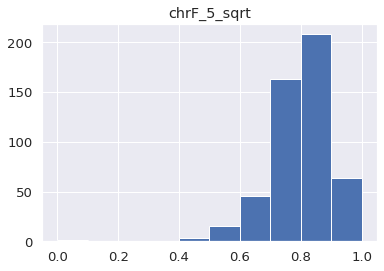

In [295]:
feature_df[['da_on_0-1']].hist()

In [248]:
feature_df

,da_score,chrR_1,chrR_2,chrR_3,chrR_4,chrR_5,chrR_6,chrR_7,chrP_1,chrP_2,...,stem_wR_1-1,stem_wP_1-1,stem_wF_1-5,stem_wR_1-5,stem_wP_1-5,stem_wF_1-6,stem_wR_1-6,stem_wP_1-6,z_da_score,da_on_0-1
0,0.452788,0.994413,0.988764,0.977401,0.965909,0.954286,0.942529,0.924855,0.941799,0.936170,...,0.937500,0.937500,0.528571,0.528571,0.528571,0.469136,0.469136,0.469136,0.792883,0.713244
1,0.485537,0.980831,0.961538,0.887460,0.812903,0.773463,0.733766,0.706840,0.841096,0.824176,...,0.695652,0.640000,0.355140,0.361905,0.330435,0.311005,0.317073,0.288889,0.848522,0.725022
2,-0.888026,0.873362,0.771930,0.678414,0.584071,0.511111,0.446429,0.408072,0.896861,0.792793,...,0.583333,0.583333,0.300000,0.300000,0.300000,0.271318,0.271318,0.271318,-1.485130,0.230992
3,0.407911,0.880597,0.820359,0.753754,0.686747,0.649547,0.615152,0.586626,0.942492,0.878205,...,0.653846,0.653846,0.308333,0.308333,0.308333,0.262411,0.262411,0.262411,0.716638,0.697103
4,-0.640085,0.949749,0.898990,0.756345,0.617347,0.523077,0.432990,0.378238,0.870968,0.824074,...,0.473684,0.500000,0.119048,0.117647,0.125000,0.102249,0.101010,0.107527,-1.063885,0.320169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.935312,0.760684,0.689655,0.643478,0.596491,0.548673,0.500000,0.459459,0.917526,0.833333,...,0.666667,0.750000,0.264706,0.257143,0.300000,0.238095,0.230769,0.272727,1.612680,0.886793
496,0.407466,0.968847,0.940625,0.865204,0.789308,0.725552,0.664557,0.606349,0.824934,0.800532,...,0.760000,0.612903,0.223140,0.234783,0.186207,0.189873,0.200000,0.157895,0.715882,0.696943
497,-1.037319,0.949580,0.898876,0.797183,0.694915,0.611898,0.531250,0.478632,0.816867,0.772947,...,0.451613,0.466667,0.145833,0.144828,0.150000,0.123675,0.122807,0.127273,-1.738775,0.177296
498,0.216968,0.814016,0.794595,0.737127,0.676630,0.634877,0.595628,0.572603,0.977346,0.954545,...,0.647059,0.758621,0.393548,0.381250,0.451852,0.360656,0.349206,0.415094,0.392230,0.628426


### Embeddings similarity

model for german: `"T-Systems-onsite/german-roberta-sentence-transformer-v2"`

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2') # use multilingual models for texts with non-english characters

sentence = ['China beschuldigte einige Mitarbeiter des Konsulats in Chengdu, Aktivitäten durchzuführen, die nicht mit ihrer Identität übereinstimmen.']

embeddings = model.encode(sentence)

for sentence, embedding in zip(sentences, embeddings):
    print(embedding) # numpy.ndarray
    print(embeddings.shape)

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

In [406]:
from scipy.stats import kendalltau, spearmanr
import numpy as np


def get_soft_ranks(x, ord_x, eps):
    curr_rank = 1
    rank_x = np.zeros_like(x)
    rank_x[ord_x[0]] = curr_rank
    prev = ord_x[0]
    for curr in ord_x[1:]:
        if abs(x[curr] - x[prev]) > eps:
            curr_rank += 1
        rank_x[curr] = curr_rank
        prev = curr
    return rank_x

def kendall_eps(x, y, eps=0.001):
    ord_x = np.array(x).argsort()[::-1]
    ord_y = np.array(y).argsort()[::-1]
    
    rank_x = get_soft_ranks(x, ord_x, eps)
    rank_y = get_soft_ranks(y, ord_y, eps)
    
    tau, p_value = kendalltau(rank_x, rank_y)
    if p_value < 0.05:
        print(f'Relation between x and y is significant since p_value = {p_value} < .05.\nKendall tau = {tau}')
    else:
        print(f'Relation between x and y is no significant since p_value = {p_value} >= .05.\nKendall tau = {tau}')
    return tau

def spearman_eps(x, y, eps=0.001):
    ord_x = np.array(x).argsort()[::-1]
    ord_y = np.array(y).argsort()[::-1]
    
    rank_x = get_soft_ranks(x, ord_x, eps)
    rank_y = get_soft_ranks(y, ord_y, eps)
    
    r, p_value = spearmanr(rank_x, rank_y)
    if p_value < 0.05:
        print(f'Relation between x and y is significant since p_value = {p_value} < .05.\nSpearman r = {r}')
    else:
        print(f'Relation between x and y is no significant since p_value = {p_value} >= .05.\nSpearman r = {r}')
    return r


In [385]:
kendall_eps(feature_df.da_score.values, feature_df['wF_1-1'].values)

Relation between x and y is significant since p_value = 2.5110451970927874e-15 < .05.
Kendall tau = 0.26503816988935547


0.26503816988935547

In [410]:
spearman_eps(feature_df.da_score.values, feature_df['wF_1-1'].values)

Relation between x and y is significant since p_value = 9.346444805457738e-12 < .05.
Spearman r = 0.2985966578560743


0.2985966578560743

In [404]:
order1 = feature_df.da_score.values.argsort()[::-1]
# print(order1)
ranks1 = order1.argsort()
# print(ranks1)

order2 = feature_df['wF_1-1'].values.argsort()[::-1]
ranks2 = order2.argsort()

In [ ]:
kendalltau(ranks1, ranks2)

In [405]:
spearmanr(ranks1, ranks2)

SpearmanrResult(correlation=0.3625836583346333, pvalue=5.571143109308738e-17)

### Z-test

In [388]:
def ztest(x, y):
    return abs(x.mean() - y.mean()) / np.sqrt(x.std()**2 + y.std()**2)

In [395]:
ztest(feature_df.da_score.values, feature_df['wP_1-4'].values)

1.0439670351886563

Question:
- how to understand where is the correct word order and where not
- so, sometimes we can move the whole collocations and sometimes not
- for example, if order is changed with named entity - then it might be problem but sometimes if whole collocation is moved it might be fine

## ANOVA test

__Compute  Variance Inflation Factor (VIF)__
https://www.investopedia.com/terms/v/variance-inflation-factor.asp#:~:text=Variance%20inflation%20factor%20(VIF)%20is,only%20that%20single%20independent%20variable. 

In [358]:
feature_df.columns

Index(['da_score', 'chrR_1', 'chrR_2', 'chrR_3', 'chrR_4', 'chrR_5', 'chrR_6',
       'chrR_7', 'chrP_1', 'chrP_2', 'chrP_3', 'chrP_4', 'chrP_5', 'chrP_6',
       'chrP_7', 'chrF_1', 'chrF_2', 'chrF_3', 'chrF_4', 'chrF_5', 'chrF_6',
       'chrF_7', 'lemma_chrR_1', 'lemma_chrR_2', 'lemma_chrR_3',
       'lemma_chrR_4', 'lemma_chrR_5', 'lemma_chrR_6', 'lemma_chrR_7',
       'lemma_chrP_1', 'lemma_chrP_2', 'lemma_chrP_3', 'lemma_chrP_4',
       'lemma_chrP_5', 'lemma_chrP_6', 'lemma_chrP_7', 'lemma_chrF_1',
       'lemma_chrF_2', 'lemma_chrF_3', 'lemma_chrF_4', 'lemma_chrF_5',
       'lemma_chrF_6', 'lemma_chrF_7', 'wF_1-4', 'wR_1-4', 'wP_1-4', 'wF_1-2',
       'wR_1-2', 'wP_1-2', 'wF_1-10', 'wR_1-10', 'wP_1-10',
       'sep_punct_wF_1-10', 'sep_punct_wR_1-10', 'sep_punct_wP_1-10',
       'wF_1-11', 'wR_1-11', 'wP_1-11', 'wF_1-1', 'wR_1-1', 'wP_1-1',
       'no_punct_wF_1-4', 'no_punct_wR_1-4', 'no_punct_wP_1-4',
       'no_punct_wF_1-12', 'no_punct_wR_1-12', 'no_punct_wP_1-12',
       '

In [300]:
feature_df.drop(['chrR_5_sqrt', 'chrF_5_sqrt'], axis=1, inplace=True)

In [296]:
corr_df = feature_df.corr()

In [57]:
# corr_df[60:]

In [297]:
corr_df[corr_df.da_score > 0.5]

,da_score,chrR_1,chrR_2,chrR_3,chrR_4,chrR_5,chrR_6,chrR_7,chrP_1,chrP_2,...,stem_wP_1-1,stem_wF_1-5,stem_wR_1-5,stem_wP_1-5,stem_wF_1-6,stem_wR_1-6,stem_wP_1-6,da_on_0-1,chrR_5_sqrt,chrF_5_sqrt
da_score,1.000000,0.278907,0.337374,0.450713,0.496490,0.542113,0.569316,0.583801,0.125398,0.203381,...,0.531706,0.579700,0.580932,0.551588,0.570962,0.571922,0.543929,1.000000,0.519015,0.524600
chrR_5,0.542113,0.664966,0.799511,0.947495,0.987847,1.000000,0.991129,0.980100,0.133762,0.333340,...,0.723164,0.741225,0.753545,0.645838,0.712472,0.724061,0.620016,0.542113,0.982703,0.973079
chrR_6,0.569316,0.609180,0.742594,0.905997,0.959032,0.991129,1.000000,0.996701,0.175419,0.360936,...,0.768130,0.785539,0.795315,0.701653,0.757771,0.766942,0.676312,0.569316,0.966745,0.963833
chrR_7,0.583801,0.581917,0.714677,0.882317,0.939568,0.980100,0.996701,1.000000,0.194578,0.373719,...,0.781646,0.812307,0.820534,0.735593,0.785369,0.793045,0.710837,0.583801,0.951966,0.952152
chrP_6,0.531880,0.198392,0.388799,0.634502,0.758665,0.826719,0.866037,0.878547,0.582265,0.716796,...,0.900484,0.762775,0.745019,0.784631,0.736139,0.718609,0.755970,0.531880,0.812600,0.867397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stem_wR_1-6,0.571922,0.368818,0.454727,0.601432,0.660668,0.724061,0.766942,0.793045,0.185056,0.292738,...,0.744642,0.993777,0.996757,0.944791,0.997204,1.000000,0.948829,0.571922,0.673290,0.680065
stem_wP_1-6,0.543929,0.161048,0.265100,0.448314,0.541245,0.620016,0.676312,0.710837,0.362015,0.437596,...,0.814046,0.962914,0.944955,0.996774,0.966693,0.948829,1.000000,0.543929,0.576357,0.610010
da_on_0-1,1.000000,0.278907,0.337374,0.450713,0.496490,0.542113,0.569316,0.583801,0.125398,0.203381,...,0.531706,0.579700,0.580932,0.551588,0.570962,0.571922,0.543929,1.000000,0.519015,0.524600
chrR_5_sqrt,0.519015,0.652701,0.791969,0.938818,0.978414,0.982703,0.966745,0.951966,0.143565,0.345736,...,0.712024,0.693417,0.704588,0.604244,0.662817,0.673290,0.576357,0.519015,1.000000,0.992937


In [266]:
high_corr_df = corr_df[corr_df.da_score > 0.59]
high_corr_cols = high_corr_df.index.values

In [267]:
high_corr_df.style.background_gradient(cmap='coolwarm')

,da_score,chrR_1,chrR_2,chrR_3,chrR_4,chrR_5,chrR_6,chrR_7,chrP_1,chrP_2,chrP_3,chrP_4,chrP_5,chrP_6,chrP_7,chrF_1,chrF_2,chrF_3,chrF_4,chrF_5,chrF_6,chrF_7,lemma_chrR_1,lemma_chrR_2,lemma_chrR_3,lemma_chrR_4,lemma_chrR_5,lemma_chrR_6,lemma_chrR_7,lemma_chrP_1,lemma_chrP_2,lemma_chrP_3,lemma_chrP_4,lemma_chrP_5,lemma_chrP_6,lemma_chrP_7,lemma_chrF_1,lemma_chrF_2,lemma_chrF_3,lemma_chrF_4,lemma_chrF_5,lemma_chrF_6,lemma_chrF_7,wF_1-4,wR_1-4,wP_1-4,wF_1-2,wR_1-2,wP_1-2,wF_1-10,wR_1-10,wP_1-10,sep_punct_wF_1-10,sep_punct_wR_1-10,sep_punct_wP_1-10,wF_1-11,wR_1-11,wP_1-11,wF_1-1,wR_1-1,wP_1-1,no_punct_wF_1-4,no_punct_wR_1-4,no_punct_wP_1-4,no_punct_wF_1-12,no_punct_wR_1-12,no_punct_wP_1-12,lemma_wF_1-4,lemma_wR_1-4,lemma_wP_1-4,lemma_wF_1-1,lemma_wR_1-1,lemma_wP_1-1,stem_wF_1-4,stem_wR_1-4,stem_wP_1-4,stem_wF_1-1,stem_wR_1-1,stem_wP_1-1,stem_wF_1-5,stem_wR_1-5,stem_wP_1-5,stem_wF_1-6,stem_wR_1-6,stem_wP_1-6,da_on_0-1
da_score,1.000000,0.278907,0.337374,0.450713,0.496490,0.542113,0.569316,0.583801,0.125398,0.203381,0.364030,0.443663,0.497961,0.531880,0.548106,0.326325,0.378472,0.478454,0.510744,0.551435,0.574869,0.587639,0.343231,0.499512,0.562678,0.584236,0.589893,0.592533,0.591983,0.216562,0.436285,0.517654,0.543770,0.551421,0.555379,0.555095,0.388536,0.514723,0.569401,0.587137,0.590473,0.591511,0.589838,0.587543,0.579407,0.528343,0.508776,0.486636,0.409602,0.614393,0.615130,0.577065,0.614393,0.615130,0.577065,0.614408,0.615602,0.578155,0.389158,0.352099,0.233729,0.578322,0.569804,0.517974,0.612159,0.613912,0.574919,0.582158,0.583532,0.548508,0.567576,0.559994,0.517712,0.588392,0.589323,0.559714,0.572672,0.563359,0.531706,0.579700,0.580932,0.551588,0.570962,0.571922,0.543929,1.000000
lemma_chrR_6,0.592533,0.459190,0.579982,0.750380,0.817355,0.876546,0.912304,0.934000,0.228278,0.377344,0.616251,0.731953,0.803264,0.849508,0.874512,0.538247,0.652386,0.795468,0.838531,0.889150,0.918925,0.938095,0.604169,0.842828,0.935355,0.975767,0.994105,1.000000,0.995250,0.399071,0.733629,0.856930,0.907358,0.931341,0.941859,0.940343,0.681718,0.864538,0.943434,0.978495,0.993639,0.997457,0.991358,0.935701,0.924718,0.845310,0.842098,0.807509,0.688512,0.949700,0.951466,0.897011,0.949700,0.951466,0.897011,0.944529,0.946838,0.894237,0.672358,0.608452,0.430625,0.939799,0.927661,0.847607,0.949800,0.952757,0.898298,0.918192,0.920804,0.861287,0.868199,0.860217,0.776804,0.908651,0.910946,0.857628,0.860809,0.851015,0.780937,0.885007,0.887246,0.836451,0.862292,0.864076,0.815340,0.592533
lemma_chrR_7,0.591983,0.432590,0.550828,0.719330,0.786928,0.849371,0.888189,0.913432,0.246343,0.386965,0.614222,0.722220,0.793439,0.839928,0.867183,0.516097,0.627306,0.768177,0.811333,0.865004,0.897546,0.920122,0.570842,0.807544,0.906688,0.954100,0.980533,0.995250,1.000000,0.407047,0.721986,0.845191,0.899457,0.929310,0.946874,0.953272,0.652540,0.832932,0.917926,0.959618,0.982544,0.994881,0.997969,0.920063,0.906016,0.842984,0.818853,0.780618,0.686169,0.955424,0.955103,0.910246,0.955424,0.955103,0.910246,0.952479,0.952792,0.909301,0.647595,0.579952,0.436194,0.922564,0.907366,0.843987,0.959672,0.960655,0.915126,0.932353,0.932906,0.882850,0.847012,0.835939,0.770219,0.923376,0.923598,0.879816,0.841446,0.828550,0.776006,0.903575,0.903887,0.861867,0.883178,0.883099,0.842738,0.591983
lemma_chrF_5,0.590473,0.441318,0.571744,0.755000,0.830370,0.889733,0.924983,0.943872,0.273905,0.424247,0.663390,0.775955,0.842249,0.883624,0.903866,0.532756,0.656633,0.810084,0.858648,0.908097,0.936283,0.952163,0.600638,0.860363,0.951175,0.985712,0.996706,0.993639,0.982544,0.450671,0.782961,0.896326,0.937063,0.951215,0.950895,0.941622,0.692194,0.889959,0.964702,0.992836,1.000000,0.994403,0.981634,0.944608,0.927947,0.874535,0.854762,0.811275,0.730801,0.941854,0.940312,0.901785,0.941854,0.940312,0.901785,0.934983,0.934137,0.896771,0.678802,0.602724,0.477379,0.950123,0.932047,0.878793,0.938898,0.938653,0.899475,0.903285,0.903177,0.854984,0.886018,0.873465,0.808820,0.893353,0.893086,0.850130,0.877062,0.862859,0.

In [268]:
high_corr_features = feature_df[high_corr_cols]

In [269]:
df_melt = pd.melt(feature_df.reset_index(), id_vars=['index'], value_vars=high_corr_cols)
# replace column names
df_melt.columns = ['sent_id', 'metric', 'value']

/home/ira/anaconda3/envs/eval_metrics/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ira/anaconda3/envs/eval_metrics/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ira/anaconda3/envs/eval_metrics/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 14.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ira/anaconda3/envs/eval_metrics/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 11.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ira/an

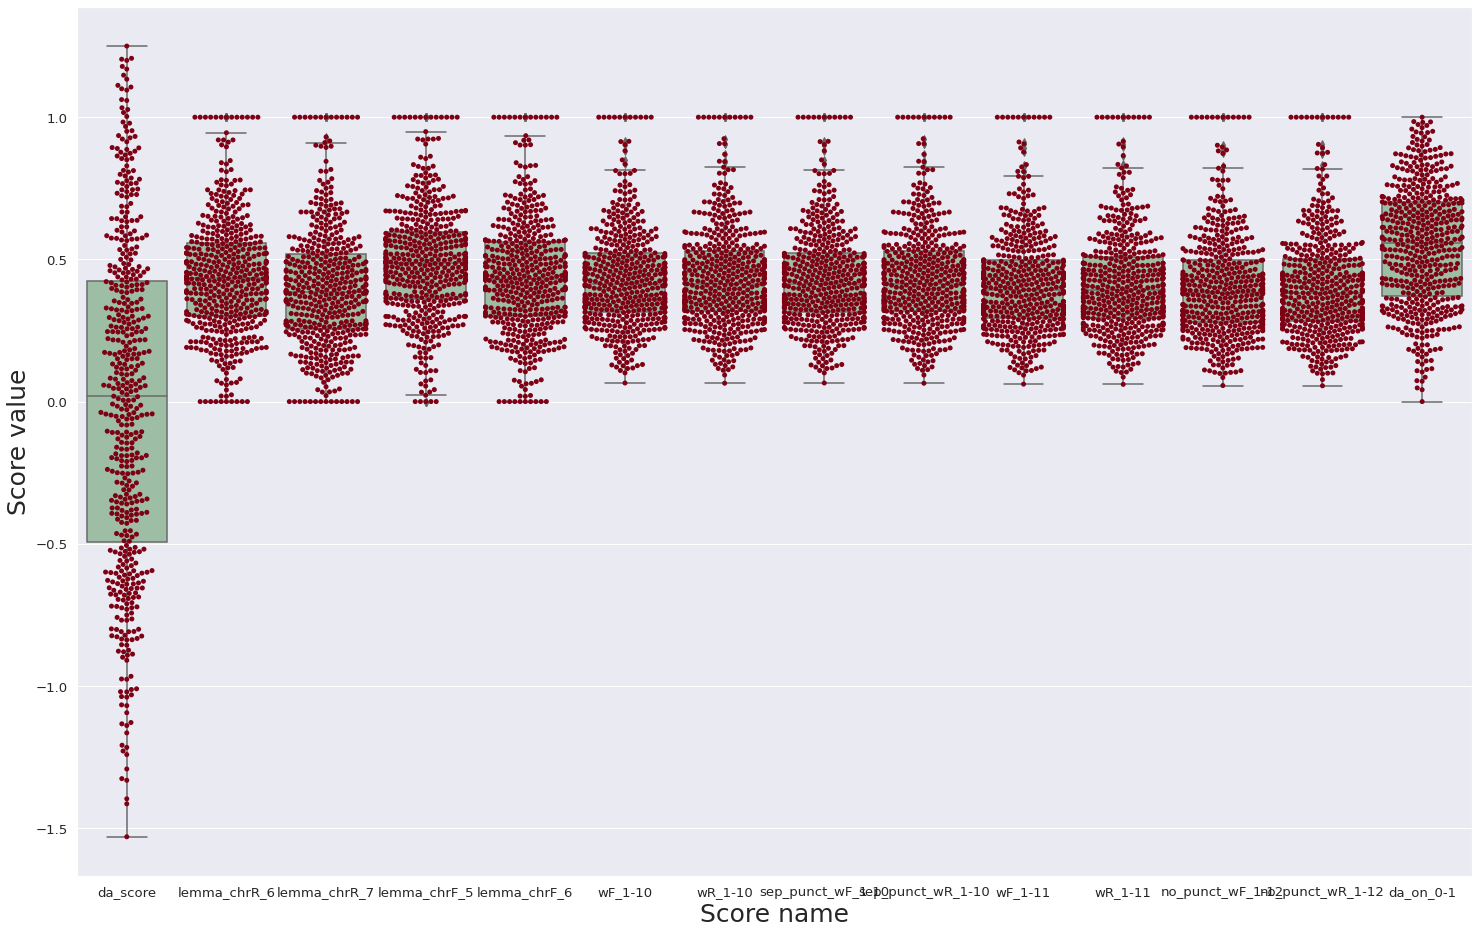

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (25,16))
sns.set(font_scale = 1.2)
ax = sns.boxplot(x='metric', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="metric", y="value", data=df_melt, color='#7d0013')
ax.set_xlabel("Score name", fontsize = 25)
ax.set_ylabel("Score value", fontsize = 25)

plt.show()

In [225]:
df_melt

,sent_id,metric,value
0,0,da_score,0.452788
1,1,da_score,0.485537
2,2,da_score,-0.888026
3,3,da_score,0.407911
4,4,da_score,-0.640085
...,...,...,...
17995,495,stem_wR_1-6,0.230769
17996,496,stem_wR_1-6,0.200000
17997,497,stem_wR_1-6,0.122807
17998,498,stem_wR_1-6,0.349206


In [304]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('value ~ metric', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
metric,104.143965,13.0,137.380983,0.0
Residual,407.373448,6986.0,NaN,NaN


## Transformers

#### Embeddings from pretrained Language Models 

In [61]:
import pandas as pd
import numpy as np

### Models:

- `"MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"`: model for multiple languages, including German

In [6]:
import torch

device = 'cpu'
label_names = ["entailment", "neutral", "contradiction"] # for sequence classification task

In [62]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Model for German language
model_name = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

premise = "Angela Merkel ist eine Politikerin in Deutschland und Vorsitzende der CDU"
hypothesis = "Emmanuel Macron is the President of France"

tokenized_input = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
output = model(tokenized_input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
prediction = torch.softmax(output["logits"][0], -1).tolist()

prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
print(prediction)

{'entailment': 0.1, 'neutral': 0.9, 'contradiction': 99.1}


In [63]:
premise = "I love you"
hypothesis = "I hate you"

tokenized_input = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
output = model(tokenized_input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
prediction = torch.softmax(output["logits"][0], -1).tolist()

prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
print(prediction)

{'entailment': 0.0, 'neutral': 0.0, 'contradiction': 100.0}


In [64]:
# labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1


In [65]:
ref_type_15 = []
for i, ref in enumerate(ref_snts_15):
    hyp = mt_snts_15[i]
    tokenized_input = tokenizer(ref, hyp, truncation=True, return_tensors="pt")
    output = model(tokenized_input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
    prediction = torch.softmax(output["logits"][0], -1).tolist()
    prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
    ref_type_15.append(prediction)
ref_type_15

[{'entailment': 98.5, 'neutral': 1.4, 'contradiction': 0.1},
 {'entailment': 95.2, 'neutral': 4.7, 'contradiction': 0.1},
 {'entailment': 5.2, 'neutral': 3.0, 'contradiction': 91.8},
 {'entailment': 91.6, 'neutral': 8.3, 'contradiction': 0.1},
 {'entailment': 1.0, 'neutral': 98.7, 'contradiction': 0.3},
 {'entailment': 99.6, 'neutral': 0.4, 'contradiction': 0.0},
 {'entailment': 98.7, 'neutral': 1.2, 'contradiction': 0.0},
 {'entailment': 99.9, 'neutral': 0.1, 'contradiction': 0.0},
 {'entailment': 97.2, 'neutral': 2.7, 'contradiction': 0.1},
 {'entailment': 98.9, 'neutral': 1.1, 'contradiction': 0.0},
 {'entailment': 99.2, 'neutral': 0.6, 'contradiction': 0.2},
 {'entailment': 99.5, 'neutral': 0.5, 'contradiction': 0.0},
 {'entailment': 99.7, 'neutral': 0.2, 'contradiction': 0.0},
 {'entailment': 99.6, 'neutral': 0.4, 'contradiction': 0.0},
 {'entailment': 0.4, 'neutral': 0.7, 'contradiction': 98.9},
 {'entailment': 98.6, 'neutral': 1.1, 'contradiction': 0.2},
 {'entailment': 99.9, 'n

In [66]:
for i, t in enumerate(ref_type_15):
    if t['contradiction'] > 75:
        print(t, f'\t human score: {da_scores_15[i]}', '\n', ref_snts_15[i], '\n', mt_snts_15[i], '\n')

{'entailment': 5.2, 'neutral': 3.0, 'contradiction': 91.8} 	 human score: -0.888025711094521 
 A 78-year-old man is to stand trial accused of running over a three-year-old girl on a pelican crossing in Fife. 
 A man stands Überfahrens 78-jähriger because of a three-year-old girl on a Fußgängerüberweg in Fife in court. 

{'entailment': 0.4, 'neutral': 0.7, 'contradiction': 98.9} 	 human score: 0.0395019684509958 
 A 78-year-old man is to stand trial accused of running over a three-year-old girl on a pelican crossing in Fife. 
 A 78-year old man stands because of the over driving of a three-year girl on a pedestrian crossing into Fife in court. 

{'entailment': 0.0, 'neutral': 0.4, 'contradiction': 99.5} 	 human score: -1.41444807445734 
 Josef Schmalzl was the head of the cannon division. 
 Josef Schmalzl became Advisor to firecrackers. 

{'entailment': 14.0, 'neutral': 7.5, 'contradiction': 78.4} 	 human score: 0.11029487468915 
 Tens of Turkish Policemen Arrested over 'Plotting' again

In [67]:
feat_df = pd.DataFrame({'bleu': sbleu_scores_15, 'human': da_scores_15})
feat_df

,bleu,human
0,0.517448,0.452788
1,0.358147,0.485537
2,0.252008,-0.888026
3,0.182574,0.407911
4,0.108007,-0.640085
...,...,...
495,0.274706,0.935312
496,0.114819,0.407466
497,0.106065,-1.037319
498,0.249054,0.216968


<AxesSubplot:>

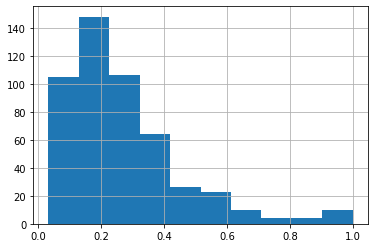

In [68]:
feat_df.bleu.hist()

In [69]:
feat1 = feat_df['bleu'].values.copy()
for i, t in enumerate(ref_type_15):
    if t['entailment'] >= 97:
        feat1[i] += 0.2
    elif t['contradiction'] > 75:
        feat1[i] = 0.1

feat_df['relation'] = feat1

In [70]:
feat_df['entailment'] = [(t['entailment'] / 100) for t in ref_type_15]
feat_df['neutral'] = [(t['neutral'] / 100) for t in ref_type_15]
feat_df['contradiction'] = [(t['contradiction'] / 100) for t in ref_type_15]

In [71]:
feat_df.corr()

,bleu,human,relation,entailment,neutral,contradiction
bleu,1.000000,0.527588,0.868141,0.127230,-0.146544,-0.018644
human,0.527588,1.000000,0.619250,0.320817,-0.255777,-0.194137
relation,0.868141,0.619250,1.000000,0.449285,-0.335600,-0.301274
entailment,0.127230,0.320817,0.449285,1.000000,-0.791563,-0.612822
neutral,-0.146544,-0.255777,-0.335600,-0.791563,1.000000,0.002197
contradiction,-0.018644,-0.194137,-0.301274,-0.612822,0.002197,1.000000


In [72]:
for i, ref in enumerate(ref_snts_15):
    hyp = mt_snts_15[i]
    tokenized_input = tokenizer(ref, hyp, truncation=True, return_tensors="pt")
    output = model(tokenized_input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
    prediction = torch.softmax(output["logits"][0], -1).tolist()
    prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}

In [73]:
from transformers import BertModel, BertTokenizer
bert_model = 'bert-base-uncased'

# tokenizer = BertTokenizer.from_pretrained(model_name)
# load
model = BertModel.from_pretrained(bert_model)
input_text = "Here is some text to encode"
# tokenizer-> token_id
input_ids = tokenizer.encode(input_text, add_special_tokens=True)
# input_ids: [101, 2182, 2003, 2070, 3793, 2000, 4372, 16044, 102]
input_ids = torch.tensor([input_ids])

with torch.no_grad():
    outputs = model(input_ids) # Models outputs are now tuples
# last_hidden_states = last_hidden_states.mean(1)
print(outputs['last_hidden_state'])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[[ 0.3242, -0.3845,  0.3960,  ...,  0.1377,  0.2971,  0.1562],
         [ 0.4119, -0.4349,  0.5136,  ...,  0.2936,  0.2415,  0.2833],
         [ 0.3434, -0.5720,  0.0643,  ..., -0.0206,  0.0792,  0.2246],
         ...,
         [ 0.4357, -0.1840,  0.4381,  ...,  0.0782,  0.1503, -0.0040],
         [ 0.4162, -0.0517,  0.6013,  ...,  0.0963,  0.1051, -0.0534],
         [ 0.4557, -0.1177,  0.4145,  ..., -0.0294,  0.1263,  0.0430]]])


In [74]:
outputs['pooler_output']

tensor([[-5.8882e-01, -2.7890e-02,  8.9067e-01,  3.6897e-01, -4.6808e-01,
         -4.3218e-02,  4.7757e-01,  1.4146e-01,  8.8255e-01, -9.8366e-01,
          7.6817e-01, -7.7410e-01,  9.7690e-01, -8.3527e-01,  9.5120e-01,
         -7.6413e-02,  4.4254e-01, -2.7504e-01,  1.8859e-01, -5.1514e-01,
          8.1723e-01, -4.0932e-01,  6.7551e-01,  1.5559e-01,  1.5264e-01,
         -8.3561e-01, -9.2878e-03,  9.3730e-01,  9.3106e-01,  8.3644e-01,
         -5.2281e-01, -3.3499e-02, -9.8921e-01, -1.2368e-01,  5.9889e-01,
         -9.4441e-01, -4.7605e-02, -6.3580e-01, -1.9748e-01,  1.7552e-02,
         -9.0912e-01, -3.0307e-02,  8.9915e-01, -7.9059e-01,  2.4357e-02,
         -1.9139e-01, -7.2257e-01,  1.2791e-01, -9.0151e-01, -9.6651e-01,
         -9.0046e-01, -9.1425e-01,  4.2346e-02,  5.5663e-03,  8.6493e-02,
          3.6471e-01, -1.3190e-01,  2.1182e-03,  3.7459e-02, -2.3126e-01,
         -3.1107e-01,  1.5171e-01,  7.0546e-01, -8.5460e-01, -9.4232e-01,
         -9.3501e-01, -1.2199e-01, -2.

In [75]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = terp_summary_df[['Ins','Del','Sub','Phrase','Shft','WdSh']].to_numpy()
y = 1 - metric_scores['wmt_human_score']
model = LinearRegression().fit(X, y)
model.coef_

NameError: name 'terp_summary_df' is not defined

### Data WMT 2021

In [ ]:
ref_type_21 = []
for i, ref in enumerate(ref_snts_21):
    hyp = mt_snts_21[i]
    tokenized_input = tokenizer(ref, hyp, truncation=True, return_tensors="pt")
    output = model(tokenized_input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
    prediction = torch.softmax(output["logits"][0], -1).tolist()
    prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
    ref_type_21.append(prediction)
ref_type_21

In [ ]:
for i, t in enumerate(ref_type_21):
    if t['entailment'] > 90:
        print(t, f'\t human score: {mqm_scores[i]}', '\n', ref_snts_21[i], '\n', mt_snts_21[i], '\n')

### Ideas:
1. Create trained metric which produces similar to MQM categories: style error, adequacy error, no error, etc. Test different classification models for this.

In [240]:
!pip install fibber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 1.2 MB/s eta 0:00:001.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.6 MB/s eta 0:00:00m eta 0:00:010:00:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 2.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 574.7/574.7 kB 5.6 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Using cached spacy_legacy-3.0.9-py2.py3-none-any.whl (20 kB)
  Using cached typer-0.4.1-py3-none-any.whl (27 kB)
  Using cached spacy_loggers-1.0.2-py3-none-any.whl (7.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.6/660.6 kB 5.8 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 4.4 M

  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 5.2 MB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 6.5 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 5.4 MB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 6.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.2 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached smart_open-5.2.1-py3-none-any.whl (58 kB)


  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=4778209 sha256=29d5027d0ac5814595bffe6c283478fe2368e60d8104aa414e681cccd10252e6
  Stored in directory: /home/ira/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171047 sha256=9bcdf2b75723047f9316c2724ea81e70a8d0f24c6946cf82235e9fb23f9ca3e6
  Stored in directory: /home/ira/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built fasttext emoji
  Attempting uninstall: libclang
    Found existing installation: libclang 12.0.0
    Uninstalling libclang-12.0.0:
      Successfully uninstalled libclang-12.0.0
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0

In [242]:
from fibber.datasets import get_demo_dataset

trainset, testset = get_demo_dataset()

from fibber.resources import download_all

# resources are downloaded to ~/.fibber
download_all()

2022-07-01 08:13:09,469 - INFO - download_utils - Load mr-demo.tgz from cache. md5 checksum is correct.
2022-07-01 08:13:09,490 - INFO - dataset_utils - Demo training set has 9594 records.
2022-07-01 08:13:09,490 - INFO - dataset_utils - Demo test set has 1068 records.
2022-07-01 08:13:09,493 - INFO - download_utils - Download bert-base-cased.tgz to /home/ira/.fibber/common/transformers_pretrained


404389632/404389632 [==============================] - 40s 0us/step


2022-07-01 08:13:53,237 - INFO - download_utils - Download universal-sentence-encoder-large_5.tar.gz to /home/ira/.fibber/common/tfhub_pretrained/universal-sentence-encoder-large_5


548921135/548921135 [==============================] - 53s 0us/step


2022-07-01 08:14:51,533 - INFO - download_utils - Download stopwords.txt to /home/ira/.fibber/common


993/993 [==============================] - 0s 0us/step
